In [1]:
!pip install tensorflow # !pip install tensorflow-gpu is also same

In [2]:
# Choosing image size
# https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

In [3]:
# import libraries
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

from glob import glob

In [4]:
IMAGE_SIZE = (180,180)
batch_size = 32

In [5]:
# folder path in google drive
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
data_dir_train

PosixPath('/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [7]:
# */*.jpg: Find all JPEG images in all subdirectories.
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2254
118


In [8]:
# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                               image_size = IMAGE_SIZE,shuffle=True,seed=123,
                                                               subset='training',
                                                               validation_split=0.2
                                                               )#label_mode='categorical'

# create validation data from Train data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                              image_size = IMAGE_SIZE,seed=123,
                                                              subset="validation",
                                                              validation_split=0.2
                                                              ) # label_mode = 'categorical'

Found 2254 files belonging to 9 classes.
Using 1804 files for training.
Found 2254 files belonging to 9 classes.
Using 450 files for validation.


In [9]:
# test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=batch_size,
                                                              image_size = IMAGE_SIZE,seed=123
                                                              ) #label_mode='categorical'

Found 118 files belonging to 9 classes.


In [10]:
# tf.keras.preprocessing.image_dataset_from_directory returns tensorflow dataset object
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [11]:
# number of classes in the dataset
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

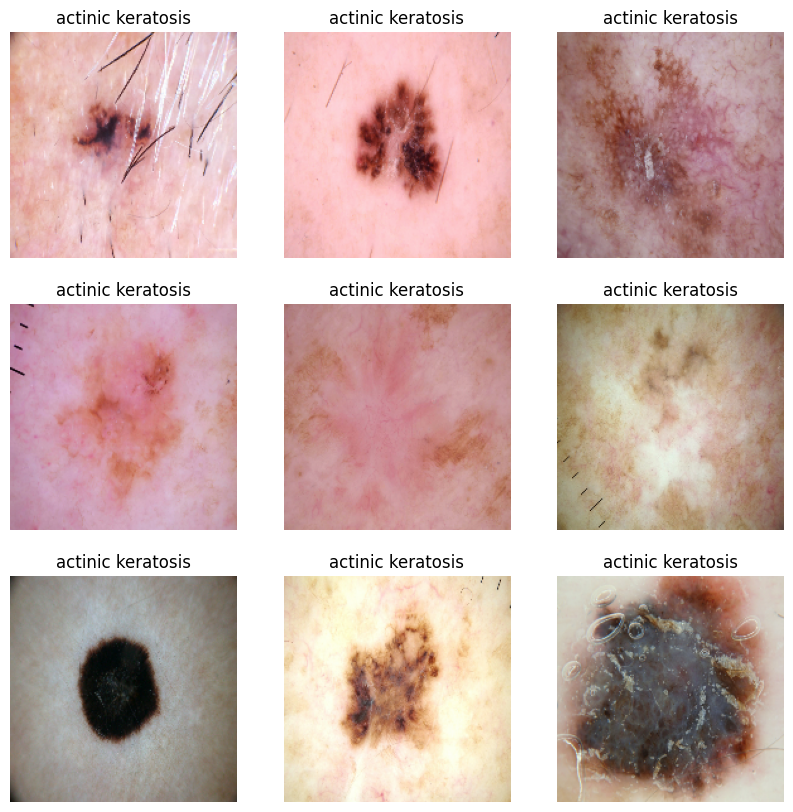

In [12]:
# print few images
# By converting the TensorFlow tensor to a NumPy array with uint8 data type,
# we ensure that the image data is in the correct format for plt.imshow to display it correctly.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


In [13]:
# img_dict = {}
# for images,labels in train_ds.take(1):
#   print(images.shape)
#   print(len(labels))
#   print(labels)
#   for i in range(len(labels)):
#     #if labels[i].numpy().astype("uint8") not in img_dict.items[0]:
#     img_dict[labels[i].numpy().astype("uint8")] = images[i].numpy().astype("uint8")

# plt.figure(figsize=(10, 10))
# #print(type(img_dict[0]))
# for i in range(len(class_names)):
#   if i in img_dict:
#     ax = plt.subplot(3,3,i+1)
#     plt.imshow(img_dict[i])
#     plt.title(class_names[i])
#     plt.axis("off")


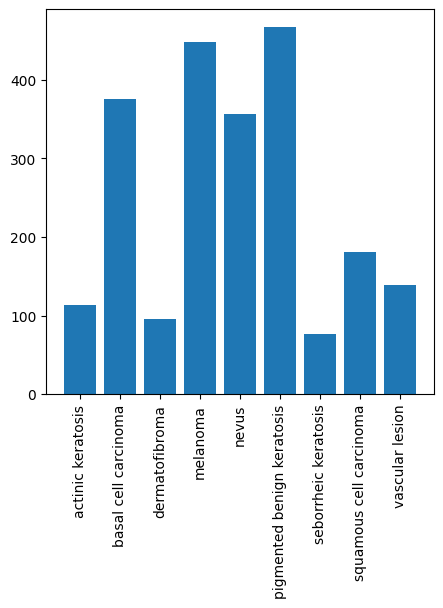

In [14]:
# visualize data in each class

class_len = []
for i in range(len(class_names)):
  class_len.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

plt.figure(figsize = (5,5))
plt.bar(class_names,class_len)
plt.xticks(rotation = 90)
plt.show()

**Augementation Method - 1**

In [15]:
# # image augmentation : cmd prompt: Image Data Augmentation with TensorFlow/Keras
# # They do not add new images to the current number of images
# # import tensorflow as tf
# # from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

# # Prepare your image data (assuming you have a directory of images)
# train_ds = datagen.flow_from_directory(
#     '/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
#     target_size=IMAGE_SIZE,
#     batch_size=batch_size,
#     seed=123,
#     shuffle=True,
#     class_mode='categorical'  #  'categorical' for multi-class classification, binary for 2 class classification
# )

# datagen_test = ImageDataGenerator(rescale=1./255)

# test_ds = datagen_test.flow_from_directory('/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
#                                                      batch_size=batch_size,
#                                                      target_size = IMAGE_SIZE,seed=123,
#                                                      class_mode='categorical')

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# build the model
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

learn_control = ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,
                                  factor=0.2,min_lr=1e-7)
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab_Notebooks/my_model/Melanoma_Model/model.keras",monitor="val_accuracy",
                             save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
#earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

# compile the model
# while both loss functions measure the difference between predicted and true probability distributions,
# sparse categorical crossentropy is often preferred due to its efficiency and simplicity in handling common classification scenarios.
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
# train the model
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=[learn_control,checkpoint])

Epoch 1/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1757 - loss: 5.4813
Epoch 1: val_accuracy improved from -inf to 0.19333, saving model to /content/drive/MyDrive/Colab_Notebooks/my_model/Melanoma_Model/model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 107s 552ms/step - accuracy: 0.1762 - loss: 5.3984 - val_accuracy: 0.1933 - val_loss: 2.1856 - learning_rate: 0.0010
Epoch 2/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2127 - loss: 2.0421
Epoch 2: val_accuracy improved from 0.19333 to 0.19556, saving model to /content/drive/MyDrive/Colab_Notebooks/my_model/Melanoma_Model/model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.2126 - loss: 2.0416 - val_accuracy: 0.1956 - val_loss: 2.0509 - learning_rate: 0.0010
Epoch 3/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2575 - loss: 1.9901
Epoch 3: val_accuracy improved from 0.19556 to 0.42000, saving model to /content/drive/MyDrive/Colab_Notebooks/my_model/Melanoma_Model/model.keras
57/57 ━━━━━━━━━━━━━━━━━

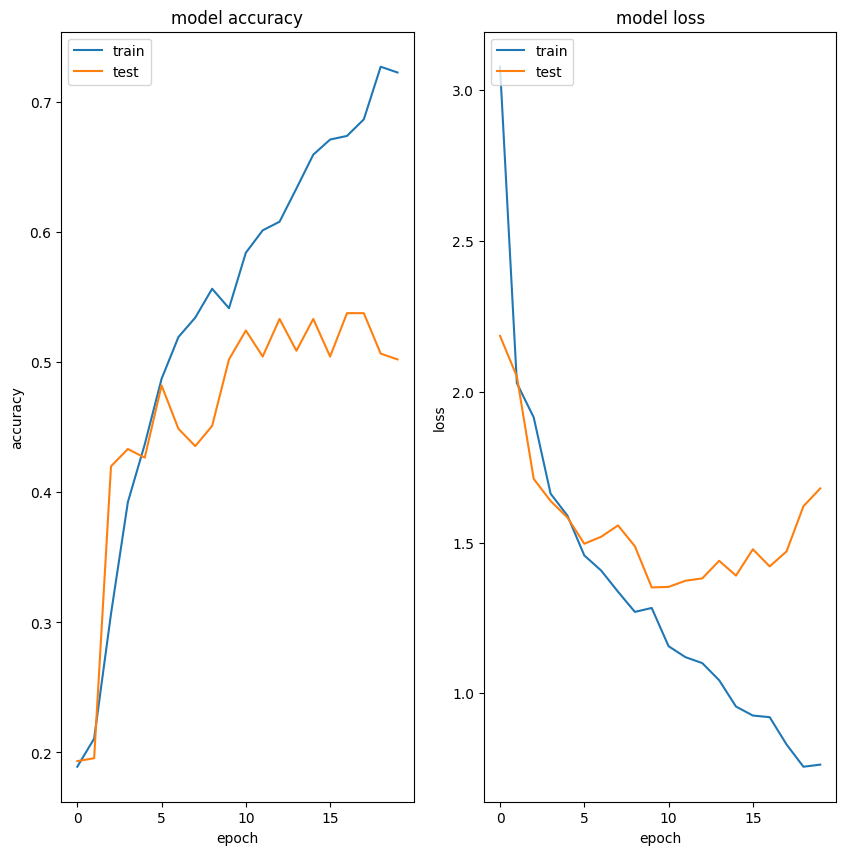

In [20]:
# visualizing the training results
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.show()

Model is overfitting as there is large gap in training and validation accuracy. Let's try to solve this using image augmentation

**Augmentaion Method-2**

In [21]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(180,180,3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomTranslation(0.2,0.2)
    ]
)

(32, 180, 180, 3) (180, 180, 3)


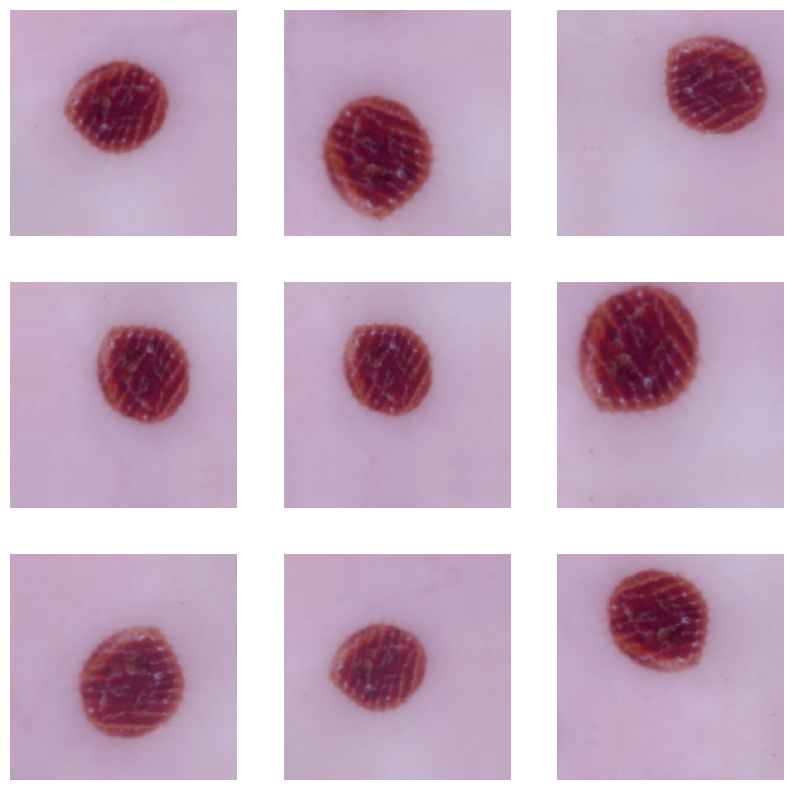

In [22]:
# check few augmented images
plt.figure(figsize=(10,10))

for images,_ in train_ds.take(1):
  print(images.shape,images[0].shape)
  for i in range(len(class_names)):
    aug_img = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

**create model with augmentaion**

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
# build the model
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

# check model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# compile the model
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
# train the model
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=[learn_control,checkpoint])

Epoch 1/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1603 - loss: 4.4568
Epoch 1: val_accuracy did not improve from 0.53778
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.1611 - loss: 4.3989 - val_accuracy: 0.2556 - val_loss: 2.0258 - learning_rate: 0.0010
Epoch 2/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2439 - loss: 1.9597
Epoch 2: val_accuracy did not improve from 0.53778
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2447 - loss: 1.9587 - val_accuracy: 0.2778 - val_loss: 1.9007 - learning_rate: 0.0010
Epoch 3/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3355 - loss: 1.8196
Epoch 3: val_accuracy did not improve from 0.53778
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3365 - loss: 1.8178 - val_accuracy: 0.4044 - val_loss: 1.7493 - learning_rate: 0.0010
Epoch 4/20
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4602 - loss: 1.5840
Epoch 4: val_accuracy did not improve from 0.53778
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms

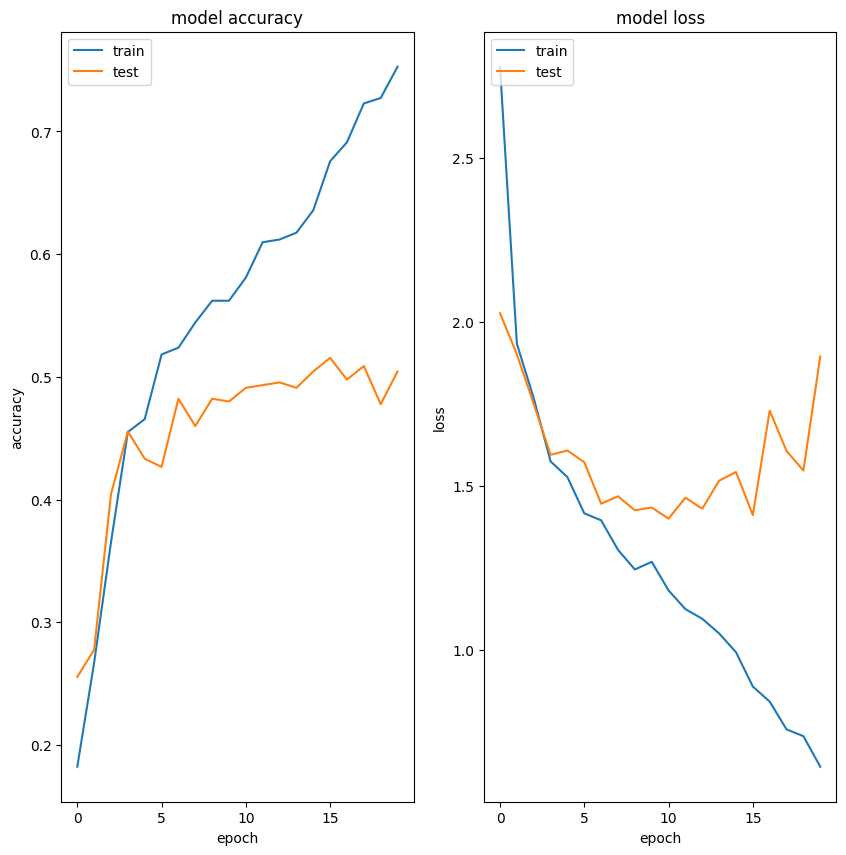

In [29]:
# visualize the training results
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.show()

Still the model is not performing well. Let's try adding new images using augmentation

**Augmentation method - 3
Handle class imbalance**

In [30]:
# this method adds new images
# install Augmentor

!pip install Augmentor

path_to_training_dataset="/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    #p.shear(probability=0.3, max_shear_left=15,max_shear_right=15)
    #p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4534327040>: 100%|██████████| 500/500 [00:04<00:00, 115.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4544223520>: 100%|██████████| 500/500 [00:04<00:00, 110.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E45342FFB50>: 100%|██████████| 500/500 [00:04<00:00, 110.94 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E454410D000>: 100%|██████████| 500/500 [00:14<00:00, 34.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2101x1943 at 0x7E45441A35E0>: 100%|██████████| 500/500 [00:11<00:00, 42.29 Samples/s]


Initialised with 467 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E45343BD2D0>: 100%|██████████| 500/500 [00:04<00:00, 108.15 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E45343CC9A0>: 100%|██████████| 500/500 [00:07<00:00, 70.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E45441A1E70>: 100%|██████████| 500/500 [00:04<00:00, 110.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E453438EF50>: 100%|██████████| 500/500 [00:04<00:00, 110.82 Samples/s]


**Reloading data again after augmentation**

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                               image_size = IMAGE_SIZE,shuffle=True,seed=123,
                                                               subset="training",
                                                               validation_split=0.2
                                                               ) #label_mode = 'categorical'

Found 6754 files belonging to 9 classes.
Using 5404 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                              image_size = IMAGE_SIZE,seed=123,
                                                              subset="validation",
                                                              validation_split=0.2
                                                              ) # label_mode = 'categorical'

Found 6754 files belonging to 9 classes.
Using 1350 files for validation.


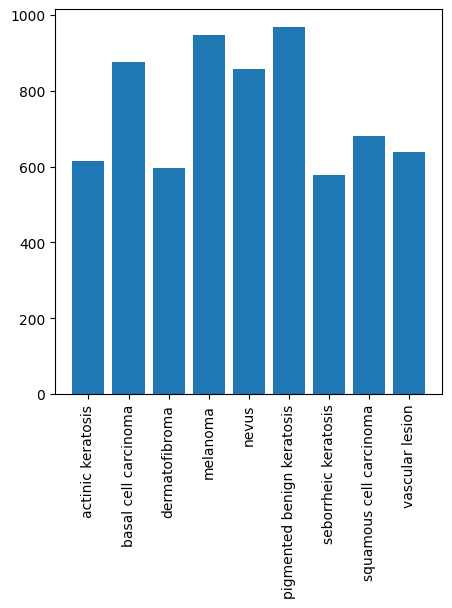

In [33]:
# visualize data in each class after augmentation
class_len = []
for i in range(len(class_names)):
  class_len.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))+len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

plt.figure(figsize = (5,5))
plt.bar(class_names,class_len)
plt.xticks(rotation = 90)
plt.show()

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# model = Sequential()

# model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))
# model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
# #model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))
# # model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
# #model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
# #model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))
# # model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
# #model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
# #model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))
# # model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
# #model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512,activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.25))
# # model.add(Dense(128,activation='relu'))
# # model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Dense(9,activation='softmax'))

# model.summary()

In [35]:
# build the model
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

# check model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 256)         │       3,965,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,738,825 (21.89 MB)

 Trainable params: 5,738,825 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# #CNN Model Architecture

# #Sequential allows you to create models layer-by-layer
# model = Sequential()

# model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# #First Convulation layer
# model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Second Convulation Layer
# model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Third Convulation Layer
# model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Dropout layer with 50% Fraction of the input units to drop.
# model.add(layers.Dropout(0.5))

# #Flatten Layer
# ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
# model.add(layers.Flatten())

# #Dense Layer
# model.add(layers.Dense(128,activation='relu'))

# #Dropout layer with 25% Fraction of the input units to drop.
# model.add(layers.Dropout(0.25))

# #Dense Layer with softmax activation function.
# #Softmax is an activation function that scales numbers/logits into probabilities.
# model.add(layers.Dense(9,activation='softmax'))

# model.summary()

In [36]:
# compile the model
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [37]:
# train the model
epochs = 40

# from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
# learn_control = ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,
#                                   factor=0.2,min_lr=1e-7)

# checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab_Notebooks/my_model/Melanoma_Model/model.keras",monitor="val_accuracy",
#                              save_best_only=True,mode="auto",verbose=1)

history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=[checkpoint,learn_control])

Epoch 1/40
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1423 - loss: 2.2197
Epoch 1: val_accuracy did not improve from 0.53778
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.1424 - loss: 2.2190 - val_accuracy: 0.2081 - val_loss: 2.0531 - learning_rate: 0.0010
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2224 - loss: 2.0017
Epoch 2: val_accuracy did not improve from 0.53778
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2224 - loss: 2.0014 - val_accuracy: 0.2778 - val_loss: 1.8554 - learning_rate: 0.0010
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3097 - loss: 1.7866
Epoch 3: val_accuracy did not improve from 0.53778
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3098 - loss: 1.7862 - val_accuracy: 0.3793 - val_loss: 1.5886 - learning_rate: 0.0010
Epoch 4/40
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3701 - loss: 1.6216
Epoch 4: val_accuracy did not improve from 0.53778
169/169 ━━━━━━━━━━━━

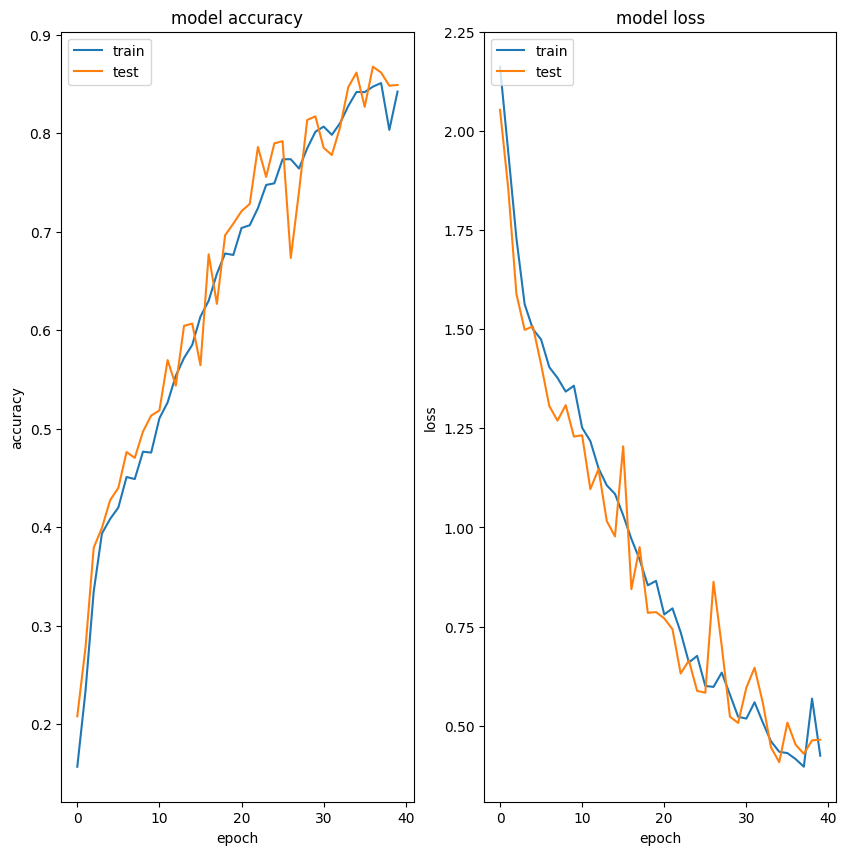

In [38]:
# visualize training results
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.show()

Model accuracy has quite improved with very less overfitting

**Test the model**

/content/drive/MyDrive/Colab_Notebooks/datasets/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/*
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[1.5482502e-09 3.7390200e-06 3.3609307e-10 1.4284307e-03 2.8233889e-03
  9.9571568e-01 8.5014733e-08 2.8613231e-05 1.6967234e-09]] 
 ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Actual Class: pigmented benign keratosis 
predictive class: pigmented benign keratosis


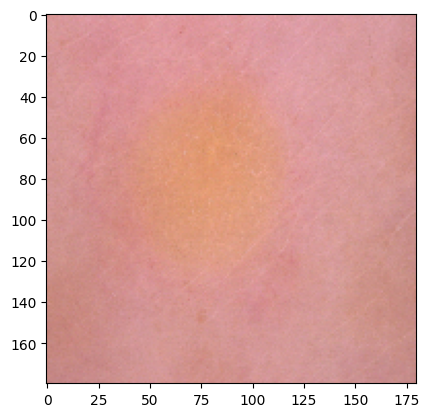

In [41]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
class_num = 5
Test_image_path = os.path.join(data_dir_test,class_names[class_num],'*')
print(Test_image_path)
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img=np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
print(pred,'\n',class_names)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class:",class_names[class_num],"\npredictive class:",pred_class)